In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
mp_pose = mp.solutions.pose

pose = mp_pose.Pose(
    static_image_mode=True, 
    min_detection_confidence=0.3, 
    model_complexity=2)

mp_drawing = mp.solutions.drawing_utils

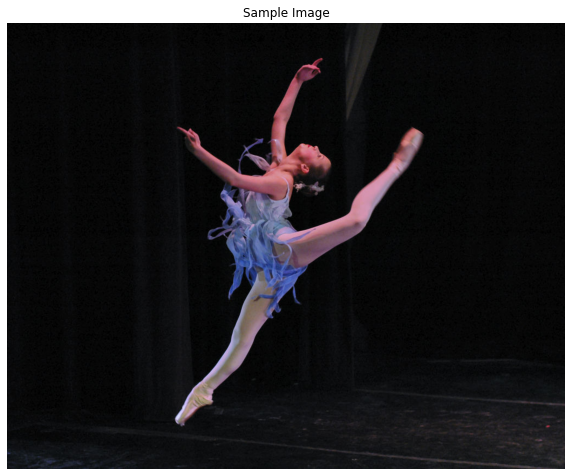

In [4]:
sample_img = cv2.imread("media/sample.jpg")
plt.figure(figsize=[10,10])
plt.title("Sample Image")
plt.axis("off")
plt.imshow(sample_img[:,:,::-1])
plt.show()

In [8]:
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
if results.pose_landmarks:
    for i in range(2):
        print((mp_pose.PoseLandmark(i).name),
              (results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]))

NOSE x: 0.5410363078117371
y: 0.28224241733551025
z: -0.2791000306606293
visibility: 0.9998681545257568

LEFT_EYE_INNER x: 0.5475030541419983
y: 0.2983400821685791
z: -0.2952289581298828
visibility: 0.9998989105224609



In [12]:
image_height, image_width, _ = sample_img.shape

if results.pose_landmarks:
    for i in range(2):
        print(mp_pose.PoseLandmark(i).name)
        print("x: ",results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width)
        print("y: ",results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height)
        print("z: ",results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width)
        print("v: ", results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility,"\n")

NOSE
x:  554.0211791992188
y:  231.1565397977829
z:  -285.7984313964844
v:  0.9998681545257568 

LEFT_EYE_INNER
x:  560.6431274414062
y:  244.34052729606628
z:  -302.314453125
v:  0.9998989105224609 



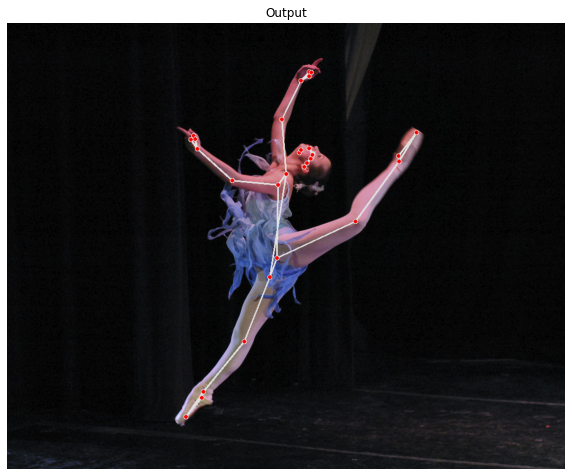

In [13]:
img_copy = sample_img.copy()

if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image=img_copy, 
        landmark_list=results.pose_landmarks, 
        connections=mp_pose.POSE_CONNECTIONS)
    
    fig = plt.figure(figsize=[10,10])
    
    plt.title("Output")
    plt.axis("off")
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

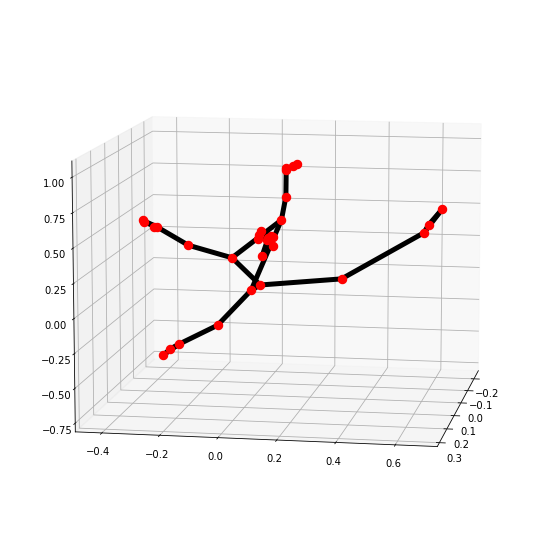

In [14]:
mp_drawing.plot_landmarks(results.pose_world_landmarks,
                          mp_pose.POSE_CONNECTIONS)

In [23]:
def detectPose(image, pose, display=True):
    """
    This function oerfoms pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value thet is if set to true the function displays the original input
                 image, the resultant and the pose landmarks in 30 plot and returns nating.
                 
    Returns:
        output_image: The input image with the detected pose landmakrs drawn.
        landmarks: A list of detected landmaks converted into their original scale.
    """
    
    output_image = image.copy()
    imageRBG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(imageRBG)
    height, width, _ = image.shape
    
    landmarks = []
    if results.pose_landmarks:
        
        mp_drawing.draw_landmarks(image=output_image, 
                                  landmark_list=results.pose_landmarks, 
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), 
                              int(landmark.y * height), 
                              int(landmark.z * width) ))
            
    if display:
        
        plt.figure(figsize=[22,22])
        plt.subplot(121)
        plt.imshow(image[:,:,::-1])
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output Image")
        plt.axis("off")
        
        mp_drawing.plot_landmarks(results.pose_world_landmarks,
                          mp_pose.POSE_CONNECTIONS)
    else:
        return output_image, landmarks

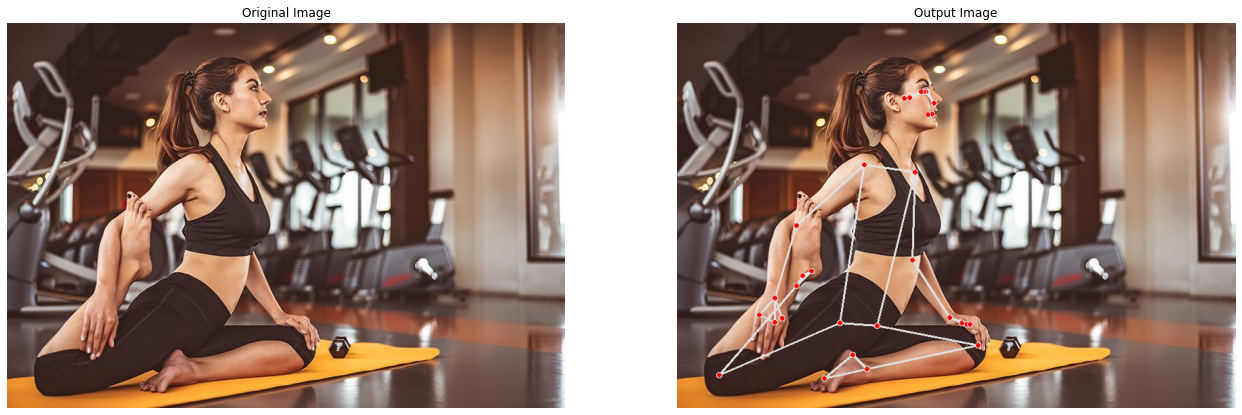

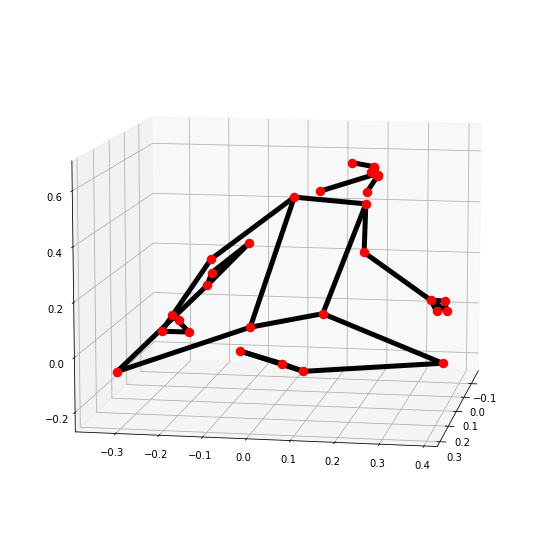

In [24]:
image = cv2.imread("media/sample2.jpg")
detectPose(image, pose, display=True)

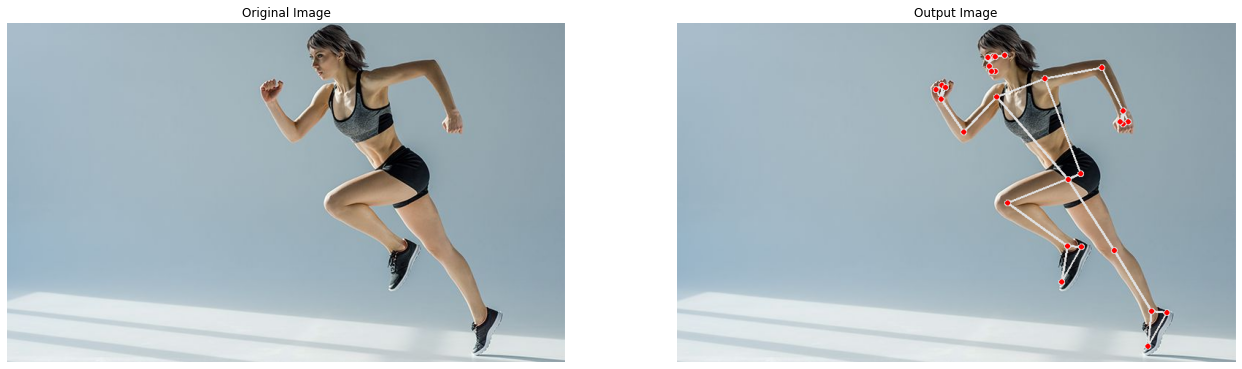

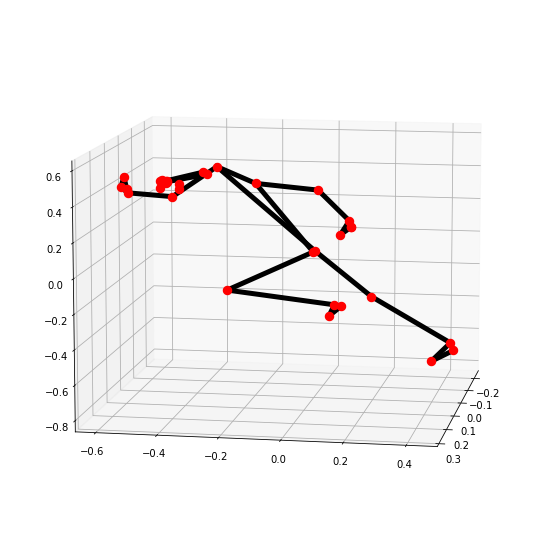

In [25]:
image = cv2.imread("media/sample3.jpg")
detectPose(image, pose, display=True)

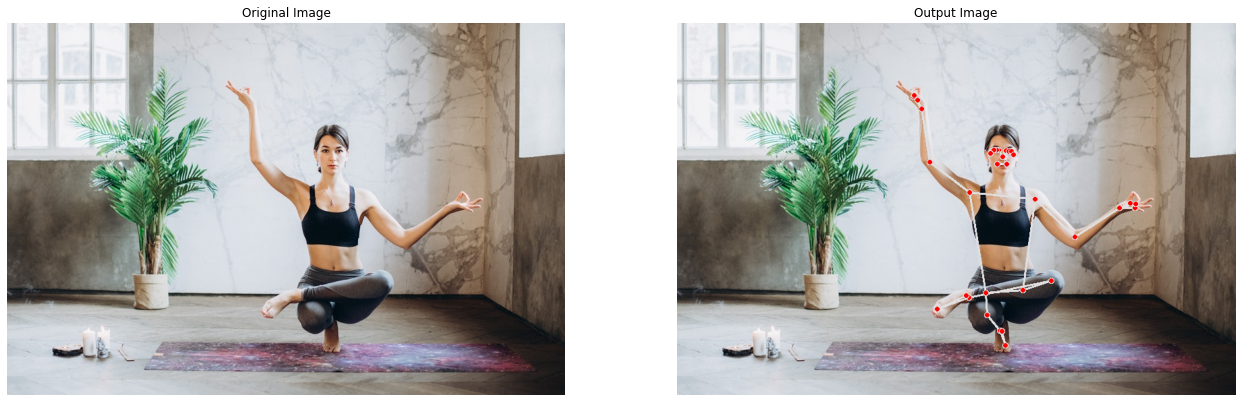

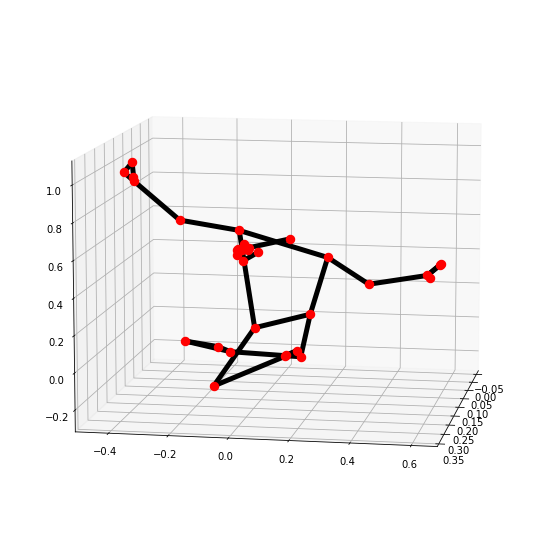

In [26]:
image = cv2.imread("media/sample4.jpg")
detectPose(image, pose, display=True)

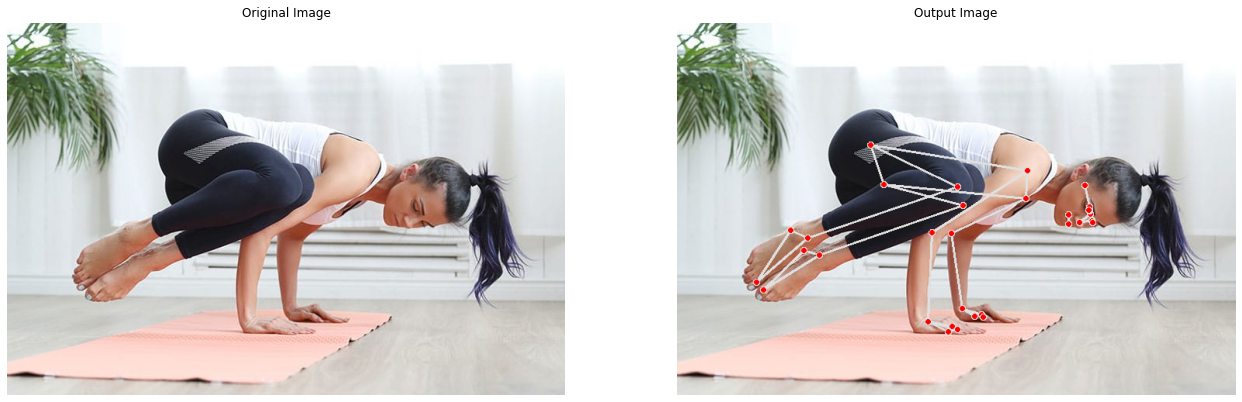

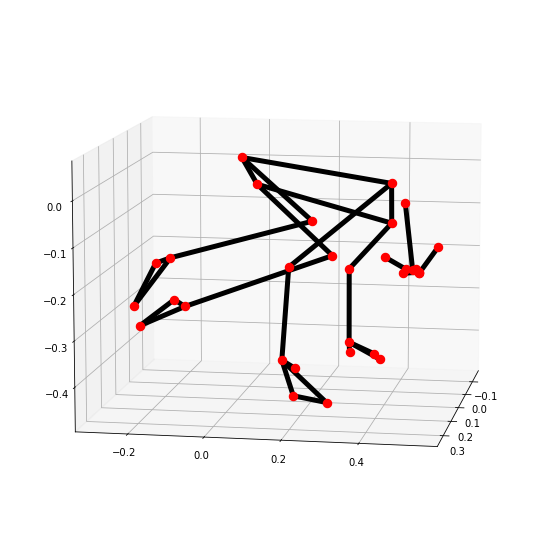

In [29]:
image = cv2.imread("media/sample5.jpg")
detectPose(image, pose, display=True)

In [35]:
pose_video = mp_pose.Pose(static_image_mode=False, 
                     min_detection_confidence=0.5, 
                     model_complexity=1)

video = cv2.VideoCapture(0)
cv2.namedWindow("Pose Detection", cv2.WINDOW_NORMAL)

video.set(3, 1280)
video.set(4, 960)

time1=0

while video.isOpened():
    ok, frame = video.read() 
    if not ok:
        break
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    frame, _ = detectPose(frame, pose_video, display=False)
    time2 = time()
    
    if (time2 - time1) > 0:
        frames_per_sec = 1.0 / (time2 - time1)
        cv2.putText(frame, "FPS {}".format(int(frames_per_sec)),
               (10, 30), cv2.FONT_HERSHEY_PLAIN,
               2, (0, 255, 0), 3)
    time1 = time2
    cv2.imshow("Pose Detection", frame)
    k = cv2.waitKey(1) & 0xFF
    if(k == 27):
        break
video.release()

cv2.destroyAllWindows()

In [38]:
def calculateAngle(landmark1, landmark2, landmark3):
    """
    This function calculates angle between three different landmarks.
    Args: 
        landmark1: The first landmark containing the x, y and z coordinates.
        landmark2: The second landmark containing the x, y and z coordinates.
        landmark3: The third landmark containing the x, y, and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.
    """
    
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
    
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    if angle < 0:
        angle +=360
        
    return angle

In [39]:
angle = calculateAngle((580, 326, 0), (642, 333, 0), (745, 125, 0))

print("The calculated ange is ", angle)

The calculated ange is  109.90265918601938


In [75]:
def classifyPose(landmarks, output_image, display=True):
    """
    This function classifies yoga poses depending upon the anges of various body joints.
    Args:
        landmarks: A list of detected landmarks of the perco whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label
        written on it and returns nothing.
    Return:
    output_image: The image with the detected pose landmarks drawn and pose label written.
    label: The classified pose label of the person in the output_image.
    """
    
    label = "Unknown Pose"
    
    color = (0, 0, 255)
    
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value], 
                                    landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                         landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                  landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                  landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value],
                                  landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                  landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value])
    
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
        if left_shoulder_angle > 80 and left_shoulder_angle < 120 and  right_shoulder_angle > 80 and right_shoulder_angle < 120:
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:
                    label = "Warrior II Pose"
            
            if left_knee_angle > 160 and left_knee_angle < 190 and right_knee_angle > 160 and right_knee_angle < 190:
                label = "T Pose"
            
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 315 and right_knee_angle < 335:
            label = "Tree Pose"
            
    if label != "Unknown Pose":
        color = (0, 255, 0)
        
    cv2.putText(output_image, label, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1])
        plt.title("Output Image")
        plt.axis("off")
    else:
        return output_image, label
    

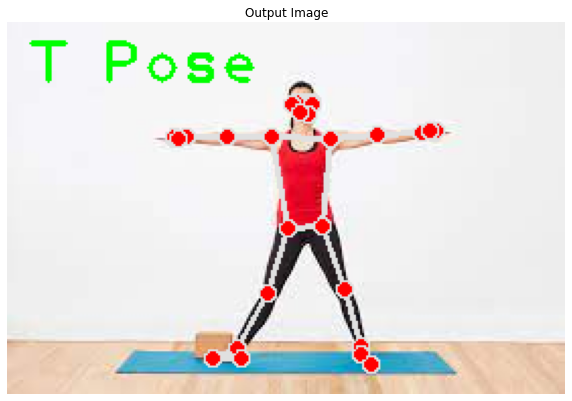

In [76]:
image = cv2.imread("media/t2.jpg")
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)